In [127]:
import cv2
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os

# Load xlsx file with labels
label_df = pd.read_excel('APS360_Project_Dataset/dataset5/labels.xlsx', dtype={'card_number': str})
label_df.columns = ['img_num', 'card_number']  

# Folder path for card images
image_1_folder = 'APS360_Project_Dataset/dataset5/img'

In [161]:
# Function to preprocess each card image and segment digits
def preprocess_and_segment_digits(image):
    # Convert to grayscale and apply binary threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold_value, binary_image = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours and filter based on contour size
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digit_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[2] > 4]  # Filter out small contours, only keep contours with width > 10 pixels
    
    # Sort contours from left to right
    digit_contours = sorted(digit_contours, key=lambda x: cv2.boundingRect(x)[0])
    
    # Segment each digit
    digit_images = []
    for cnt in digit_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        digit_image = binary_image[y:y+h, x:x+w]
        digit_image = cv2.resize(digit_image, (32, 32))  # Resize to a standard size
        digit_images.append(digit_image)
    
    return digit_images  # Each element in digit_images is a 32x32 binary image (np array) containing a single digit

# Function to extract HOG features from a list of digit images
def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, orientations=16, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)


In [162]:
# Initialize lists to store full card number sequences and digit-level data
y_true_sequences = []       # True sequences (full card numbers)
y_pred_sequences = []       # Predicted sequences (full card numbers, populated after prediction)
all_digit_pred = []         # Predicted digit images (individual digits)
all_digit_labels = []       # True digit labels (individual digits)

# Loop through each image and label in the dataset
for index, row in label_df.iterrows():
    # Check for missing card number and skip if missing
    card_number = str(int(row['card_number'])) if pd.notna(row['card_number']) else None
    if card_number is None:
        print(f"Warning: Skipped row {index} due to missing card number.")
        continue
    
    # Convert card_number to a string with only digits (removes any non-numeric characters)
    card_number = ''.join(filter(str.isdigit, card_number))
    y_true_sequences.append(card_number)  # Add to true sequence list

    # Read and preprocess the image
    image_path = os.path.join(image_1_folder, f"img_{row['img_num']}.png")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue

    # Preprocess image and segment digits
    digit_images = preprocess_and_segment_digits(image)
    
    # Allow partial matching if segmentation count doesn't match expected length
    min_length = min(len(digit_images), len(card_number))

    if min_length > 0:
        predicted_sequence = []
        
        for i in range(min_length):
            digit_img = digit_images[i]
            predicted_sequence.append(digit_img)         # Store each segmented digit image

            all_digit_pred.append(digit_img)           # Keep for digit-level analysis
            all_digit_labels.append(int(card_number[i])) # Corresponding true label

        # # Form the predicted sequence from available segmented digits
        label_of_predicted_digits_length = ''.join([str(int(card_number[i])) for i in range(min_length)])
        y_pred_sequences.append(predicted_sequence)

        print(f"Processed card number {row['img_num']}: True Label= {card_number}, Label of predicted digits length = {label_of_predicted_digits_length}")

    else:
        print(f"Warning: No valid segments for {image_path}, skipped.")


Processed card number 1: True Label= 625156888888888, Label of predicted digits length = 625156888888888
Processed card number 2: True Label= 6227000411010422600, Label of predicted digits length = 6
Processed card number 3: True Label= 9559980210373015416, Label of predicted digits length = 9
Processed card number 4: True Label= 6228484150498182715, Label of predicted digits length = 6228484150498182715
Processed card number 5: True Label= 9559980095637130717, Label of predicted digits length = 9
Processed card number 6: True Label= 6212842930330021010, Label of predicted digits length = 6212842930330021010
Processed card number 7: True Label= 6217002990100619141, Label of predicted digits length = 6217002990100619141
Processed card number 8: True Label= 8888888888888888, Label of predicted digits length = 8888888888888888
Processed card number 9: True Label= 6222802212011989816, Label of predicted digits length = 62228022120119898
Processed card number 10: True Label= 621985610000599

[ WARN:0@15925.064] global loadsave.cpp:241 findDecoder imread_('APS360_Project_Dataset/dataset5/img/img_17.png'): can't open/read file: check file path/integrity


In [167]:
# X contains HOG features for each digit image, y contains the true labels (digits)
X = extract_hog_features(all_digit_pred)  # HOG features
y = np.array(all_digit_labels)            # True digit labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train the KNN model
# k = 20  # Number of neighbors, can experiment with different values
# knn_model = KNeighborsClassifier(n_neighbors=k)
# knn_model.fit(X_train, y_train)

# Define the parameter distribution
param_dist = {
    'C': stats.uniform(0.1, 100),         # Randomly samples C values from 0.1 to 100
    'kernel': ['linear', 'rbf', 'poly'],  # Choose between linear, RBF, and polynomial kernels
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]  # Options for gamma
}

# Initialize the SVM model
svm_model = SVC()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, cv=5, n_iter=100, scoring='accuracy', verbose=2, n_jobs=-1, random_state=78)

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Retrieve the best parameters and best model
best_params = random_search.best_params_
best_svm_model = random_search.best_estimator_
# Train the model on the training data
svm_model.fit(X_train, y_train)
train_accuracy = svm_model.score(X_train, y_train)

# Optionally, evaluate the model on the test set to check accuracy
test_accuracy = svm_model.score(X_test, y_test)
print(f"SVM Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"SVM Test Accuracy: {test_accuracy * 100:.2f}%")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time=   0.2s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time=   0.2s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time=   0.2s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....C=76.16209251584098, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time=   0.2s
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time=   0.2s
[CV] END .....C=76.16209251584098, gamma=0.01,

Test Accuracy: 25.39%
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.70      0.37        40
           1       0.00      0.00      0.00        23
           2       0.14      0.12      0.13        25
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        13
           6       0.43      0.45      0.44        20
           7       0.00      0.00      0.00         6
           8       0.24      0.23      0.23        40
           9       0.00      0.00      0.00        12

    accuracy                           0.25       193
   macro avg       0.11      0.15      0.12       193
weighted avg       0.17      0.25      0.19       193



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


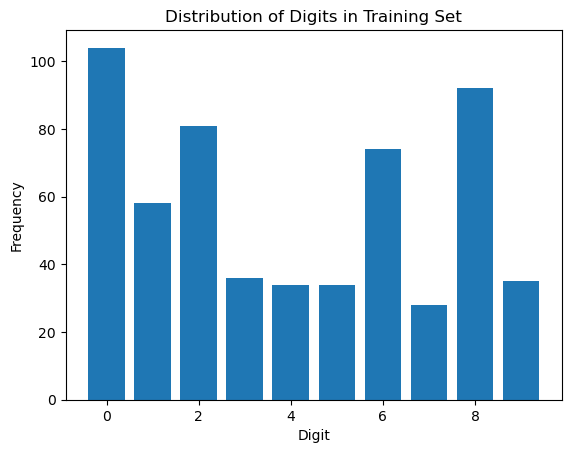

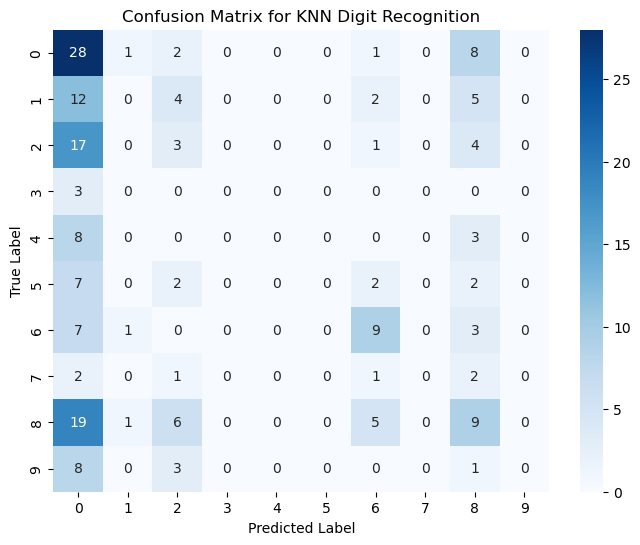

In [169]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Print a detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.title("Distribution of Digits in Training Set")
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN Digit Recognition")
plt.show()


In [123]:
# Function to predict a full card number sequence
def predict_card_number(digit_images, knn_model):
    predicted_digits = []
    
    for digit_img in digit_images:
        # Extract HOG features for the digit image
        hog_feature = extract_hog_features([digit_img])[0]  # Get the first element since it's a single image

        # Use KNN model to predict the digit
        predicted_digit = knn_model.predict([hog_feature])[0]  # Predict and get the digit label
        predicted_digits.append(str(predicted_digit))

    # Combine all predicted digits to form the card number
    predicted_card_number = ''.join(predicted_digits)
    return predicted_card_number

# Example usage for a new card image
# Assuming `digit_images` is a list of segmented digit images from a single card image
# digit_images = preprocess_and_segment_digits(new_card_image)
# predicted_card_number = predict_card_number(digit_images, knn_model)
# print(f"Predicted Card Number: {predicted_card_number}")

# Load the labels
set_labels = pd.read_csv('APS360_Project_Dataset/dataset1/bank_card_images_train_labels.csv')
# set_labels.columns = ['index', 'card_number', '', '', '', '']  

image_1_folder = 'APS360_Project_Dataset/dataset1/bank_card_images_train'

# Initialize lists to store true and predicted card number sequences
true_card_numbers = []
predicted_card_numbers = []

# Loop through each image and label in the dataset
for index, row in set_labels.iterrows():
    # Read the image
    image_path = os.path.join(image_1_folder, str(row['index']))
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue

    # True card number for the image
    true_card_number = str(row['card_num'])
    true_card_numbers.append(true_card_number)

    # Preprocess and segment digits from the image
    digit_images = preprocess_and_segment_digits(image)

    # Predict each digit in the segmented images
    predicted_digits = []
    for digit_img in digit_images:
        # Extract HOG features for the digit
        hog_feature = extract_hog_features([digit_img])[0]  # Extract feature and get the single array element
        # Predict the digit using the KNN model
        predicted_digit = svm_model.predict([hog_feature])[0]
        predicted_digits.append(str(predicted_digit))  # Store as a string for joining later

    # Combine predicted digits to form the full card number
    predicted_card_number = ''.join(predicted_digits)
    predicted_card_numbers.append(predicted_card_number)

    print(f"True Card Number: {true_card_number}, Predicted Card Number: {predicted_card_number}")

# Calculate accuracy of full card number predictions
correct_sequences = sum(1 for true, pred in zip(true_card_numbers, predicted_card_numbers) if true == pred)
sequence_accuracy = correct_sequences / len(true_card_numbers) * 100
print(f"Full Card Number Prediction Accuracy: {sequence_accuracy:.2f}%")

# Optional: Detailed evaluation of digit-level predictions
y_true_digits = [int(digit) for card in true_card_numbers for digit in card]
y_pred_digits = [int(digit) for card in predicted_card_numbers for digit in card]

print("Digit-Level Classification Report:\n", classification_report(y_true_digits, y_pred_digits))

# Plot confusion matrix for digit-level predictions
conf_matrix = confusion_matrix(y_true_digits, y_pred_digits)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN Digit Recognition")
plt.show()

True Card Number: 62257583.0, Predicted Card Number: 0800880688888880808080800800088008088080888080088028000800802880028
True Card Number: 62257583.0, Predicted Card Number: 068080088008020088820888080080888080280280808888828088080822888080028808800288888
True Card Number: 62257583.0, Predicted Card Number: 0802200202008828000080
True Card Number: 62257583.0, Predicted Card Number: 80688088206882888282800208008088000
True Card Number: 62257583.0, Predicted Card Number: 60006688882828206688080808802
True Card Number: 62257583.0, Predicted Card Number: 0800880008000800208002000080882288880800800888880
True Card Number: 62257583.0, Predicted Card Number: 86088080860020862808800000002
True Card Number: 62257583.0, Predicted Card Number: 06200008082200880288800000080888
True Card Number: 62257583.0, Predicted Card Number: 008028680800008008
True Card Number: 62257583.0, Predicted Card Number: 80088888868880002602202086886820000008200080882080
True Card Number: 62257583.0, Predicted Card Num

[ WARN:0@15322.979] global loadsave.cpp:241 findDecoder imread_('APS360_Project_Dataset/dataset1/bank_card_images_train/nan'): can't open/read file: check file path/integrity


True Card Number: 62257683.0, Predicted Card Number: 86
True Card Number: 62257683.0, Predicted Card Number: 6
True Card Number: 62257683.0, Predicted Card Number: 0008000020008088808028200808880200888288
True Card Number: 62257683.0, Predicted Card Number: 06
True Card Number: 62257683.0, Predicted Card Number: 0068
True Card Number: 62257683.0, Predicted Card Number: 06
True Card Number: 62257683.0, Predicted Card Number: 6
True Card Number: 62257683.0, Predicted Card Number: 008
True Card Number: 62257683.0, Predicted Card Number: 8000
True Card Number: 62257683.0, Predicted Card Number: 0860880220
True Card Number: 62257683.0, Predicted Card Number: 628080000
True Card Number: 62257683.0, Predicted Card Number: 06680088
True Card Number: 62257683.0, Predicted Card Number: 60000600800
True Card Number: nan, Predicted Card Number: 06
True Card Number: nan, Predicted Card Number: 6
True Card Number: nan, Predicted Card Number: 0862
True Card Number: nan, Predicted Card Number: 8806082

[ WARN:0@15326.313] global loadsave.cpp:241 findDecoder imread_('APS360_Project_Dataset/dataset1/bank_card_images_train/nan'): can't open/read file: check file path/integrity


True Card Number: 62257688.0, Predicted Card Number: 682028880028802008880028028200880680288080208008826288882028808880222008000006008000082802200002000080826800082002808808000800800080208020000220200800880000008288080882008828088802
True Card Number: 62257688.0, Predicted Card Number: 880888088208888888802888200008202208228088020000802080080800002208000802008080200022028000608000808008000800800006028802080008060808008008800020000880088208028000
True Card Number: 62257588.0, Predicted Card Number: 688000000000
True Card Number: 62257588.0, Predicted Card Number: 6
True Card Number: 62257588.0, Predicted Card Number: 00808608000880808802882080880088888880088808882880800088882880020002008
True Card Number: 62257588.0, Predicted Card Number: 60
True Card Number: 62257588.0, Predicted Card Number: 60
True Card Number: 62257588.0, Predicted Card Number: 6000
True Card Number: 62257588.0, Predicted Card Number: 668008
True Card Number: 62257588.0, Predicted Card Number: 60800020
True Card Nu

ValueError: invalid literal for int() with base 10: '.'